# Learning and Decision Making

## Laboratory 4: Partially observable Markov decision problems

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. Modeling

Consider once again the guessing game domain described in the Homework and which you described as a POMDP.

Recall that:

* The opponent can hold one of two cards in hand: an Ace of Clubs (A&clubs;) and an Ace of Diamonds (A&diams;). The agent must guess which card the opponent is holding. 

* For every right answer, the agent wins 1EUR, and every wrong answer costs the agent 1EUR. 

* The agent can also try to _peek_. 

* When the agent peeks, it sees the right card with a probability of 0.9 and the wrong card with probability 0.1.

* The game restarts whenever the agent makes a guess.

Consider throughout that $\gamma=0.9$.

---

#### Activity 1.        

Implement your POMDP in Python. In particular,

* Create a list with all the states;
* Create a list with all the actions;
* Create a list with all the observations
* For each action, define a `numpy` array with the corresponding transition probabilities;
* For each action, define a `numpy` array with the corresponding observation probabilities;
* Define a `numpy`array with the cost that you defined in your homework.

The order for the states and actions used in the transition probability and cost matrices should match that in the lists of states and actions. 

**Note**: Don't forget to import `numpy`.

---

In [1]:
import numpy as np

## The PO Markov Decision Process
X = ["Holding AC", "Holding AD"]
A = ["Guess AC", "Guess AD", "Peek"]
Z = ["Nothing", "AC", "AD"]
P_GAC = np.array([[0.5, 0.5], [0.5, 0.5]])
P_GAD = P_GAC
P_Peek = np.array([[1, 0], [0,1]])
O_GAC = np.array([[1,0,0], [1,0,0]])
O_GAD = O_GAC
O_Peek = np.array([[0,0.9,0.1], [0,0.1,0.9]])
C = np.array([[0,1,0.5], [1,0,0.5]])
gamma = 0.9

## Some useful mappings
action_matrixes = {"Guess AC":P_GAC, "Guess AD":P_GAD, "Peek":P_Peek}
observation_matrixes = {"Guess AC":O_GAC, "Guess AD":O_GAD, "Peek":O_Peek}

### 2. Sampling

You are now going to sample random trajectories of your POMDP and observe the impact it has on the corresponding belief.

---

#### Activity 2.

Generate a random POMDP trajectory using a uniformly random policy. In particular, from a random initial state $x_0$ generate:

1. A sequence of 10,000 states by selecting the actions uniformly at random;
2. The corresponding sequence of 10,000 actions;
3. The corresponding sequence of 10,000 observations.

---

In [2]:
from random import randint

policy = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3]]) #Uniform random policy

x_initial = X[randint(0, len(X)-1)] #Choose a random initial state

trajectory = []
actions = []
observations = []

currentState = x_initial
for i in range(10000):
    action = np.random.choice(A, p=policy[X.index(currentState)]) #Choosing an action from the policy
    observation = np.random.choice(Z, p=observation_matrixes[action][X.index(currentState)]) #Getting an observation
    actions += [action]
    observations += [observation]
    trajectory += [currentState]
    currentState = np.random.choice(X, p=action_matrixes[action][X.index(currentState)]) #Updating our current state

#for j in range(10):
#    print("In state " + trajectory[j] + " did action " + actions[j] + " and observed " + observations[j])

---

#### Activity 3.

For the POMDP trajectory generated in Activity 2, compute the corresponding sequence of beliefs, assuming that the initial belief is $\mathbf{b}_0=[0.5, 0.5]$. Report the resulting beliefs, ignoring duplicate beliefs or beliefs whose distance is smaller than $10^{-4}$.

**Note 1:** You may want to define a function `belief_update` that receives a belief, an action and an observation and returns the updated belief.

**Note 2:** To compute the distance between vectors, you may find useful `numpy`'s function `linalg.norm`.


---

In [3]:
def belief_update(belief, action, observation):
    soma = 0
    numerator = np.dot(np.dot(belief, action_matrixes[action]), np.diag(observation_matrixes[action][:,Z.index(observation)]))
    for x in np.nditer(numerator):
        soma += x
    return numerator/soma

def beliefDifferent(nextBelief, beliefSequence):
    for belief in beliefSequence:
        if (np.linalg.norm(nextBelief - belief) < 10**(-4)):
            return False
    return True

initial_belief = np.array([0.5, 0.5])

belief_sequence = [initial_belief]

currentBelief = initial_belief
for i in range(10000):
    nextBelief = belief_update(currentBelief, actions[i], observations[i])
    currentBelief = nextBelief
    if beliefDifferent(nextBelief, belief_sequence):
        belief_sequence += [nextBelief]

#print("BELIEFS " + str(belief_sequence))
#print()
#print("ACTIONS " + str(actions[0:10]))
#print()
#print("OBSERVATIONS " + str(observations[0:10]))

### 3. Solution methods

In this section you are going to compare different non-exact solution methods.

---

#### Activity 4

Compute the solution for the underlying MDP and report the corresponding optimal policy and optimal cost-to-go. 

** Note:** You may reuse code from previous labs.

---

In [4]:
###### Policy Iteration ######

i = 0
pi = policy
quit = False
while not quit:
    cpi = np.diag(pi[:,0]).dot(C[:,0]) + np.diag(pi[:,1]).dot(C[:,1]) + np.diag(pi[:,2]).dot(C[:,2])
    Ppi = np.diag(pi[:,0]).dot(P_GAC) + np.diag(pi[:,1]).dot(P_GAD) + np.diag(pi[:,2]).dot(P_Peek)
    J = np.linalg.inv(np.eye(2) - gamma * Ppi).dot(cpi)
    J_fix = []
    for el in J:
        J_fix += [[el]]
    J = np.array(J_fix)
    Q_GAC = C[:,0:1] + gamma * P_GAC.dot(J)
    Q_GAD = C[:,1:2] + gamma * P_GAD.dot(J)
    Q_Peek = C[:,2:3] + gamma * P_Peek.dot(J)
    pinew = np.zeros((2,3))
    pinew[:, 0, None] = np.isclose(Q_GAC, np.min([Q_GAC,Q_GAD, Q_Peek], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    pinew[:, 1, None] = np.isclose(Q_GAD, np.min([Q_GAC,Q_GAD, Q_Peek], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    pinew[:, 2, None] = np.isclose(Q_Peek, np.min([Q_GAC,Q_GAD, Q_Peek], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    pinew = pinew / np.sum(pinew, axis=1, keepdims=True)
    quit = (pi == pinew).all()
    pi = pinew
    i += 1
print("The optimal policy for the MDP is: ")
print(pi)
print()

###### Value Iteration ######

J = np.zeros((len(X),1))
err = 1
i = 0
while err > 1e-8:
    Q_GAC = C[:,0:1] + gamma * P_GAC.dot(J)
    Q_GAD = C[:,1:2] + gamma * P_GAD.dot(J)
    Q_Peek = C[:,2:3] + gamma * P_Peek.dot(J)
    J_new = np.min([Q_GAC, Q_GAD,Q_Peek], axis=0)
    err = np.linalg.norm(J_new-J)
    i += 1
    J = J_new

print("The optimal cost-to-go for the MDP is: ")
print(J)

The optimal policy for the MDP is: 
[[ 1.  0.  0.]
 [ 0.  1.  0.]]

The optimal cost-to-go for the MDP is: 
[[ 0.]
 [ 0.]]


---

#### Activity 5

For each of the beliefs computed in Activity 3, compute the action prescribed by:

* The MLS heuristic;
* The AV heuristic;
* The Q-MDP heuristic.

---

In [5]:
pi_mdp = {"Holding AC":"Guess AC", "Holding AD":"Guess AD"} #This is our optimal policy computed in the previous step

def I(condition):
    if condition:
        return 1
    return 0

###### MLS Heuristic ######
mls_actions = []
for bel in belief_sequence:
    mls_actions += [pi_mdp[X[np.where(bel==np.max(bel))[0][0]]]] ## [0][0] because np.where returns a tuple, not the integer directly
    
print(mls_actions)
    
###### AV Heuristic ######
av_actions = []
for bel in belief_sequence:
    a_max = A[0]
    soma_max = 0
    for act in A:
        soma = 0
        for x in range(len(X)):
            soma += bel[x] * I(act==pi_mdp[X[x]])
        if soma > soma_max:
            soma_max = soma
            a_max = act
    av_actions += [a_max]
    
print(av_actions)
    
###### Q-MDP Heuristic ######
q_mdp_actions = []
Q_MDP = np.column_stack((Q_GAC, Q_GAD, Q_Peek))
for bel in belief_sequence:
    q_mdp_actions += [A[np.where(np.dot(bel,Q_MDP)==np.min(np.dot(bel,Q_MDP)))[0][0]]]

print(q_mdp_actions)

['Guess AC', 'Guess AC', 'Guess AC', 'Guess AC', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AC', 'Guess AC']
['Guess AC', 'Guess AC', 'Guess AC', 'Guess AC', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AC', 'Guess AC']
['Guess AC', 'Guess AC', 'Guess AC', 'Guess AC', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AD', 'Guess AC', 'Guess AC']


---

#### Activity 6

Suppose that the optimal cost-to-go function for the POMDP can be represented using the $\alpha$-vectors

$$
\left\{
\begin{bmatrix}
2.795\\
3.795
\end{bmatrix},
\begin{bmatrix}
3.795\\
2.795
\end{bmatrix},
\begin{bmatrix}
3.105\\
3.105
\end{bmatrix}\right\}$$

corresponding to the actions 'Guess clubs', 'Guess diamonds' and 'Peek', respectively. Represent the optimal cost-to-go function and compare the optimal policy with the MDP heuristics from Activity 5 in the beliefs computed in Activity 3.

** Note: ** Don't forget to import `matplotlib`, and use the magic `%matplotlib notebook`.

---

<IPython.core.display.Javascript object>


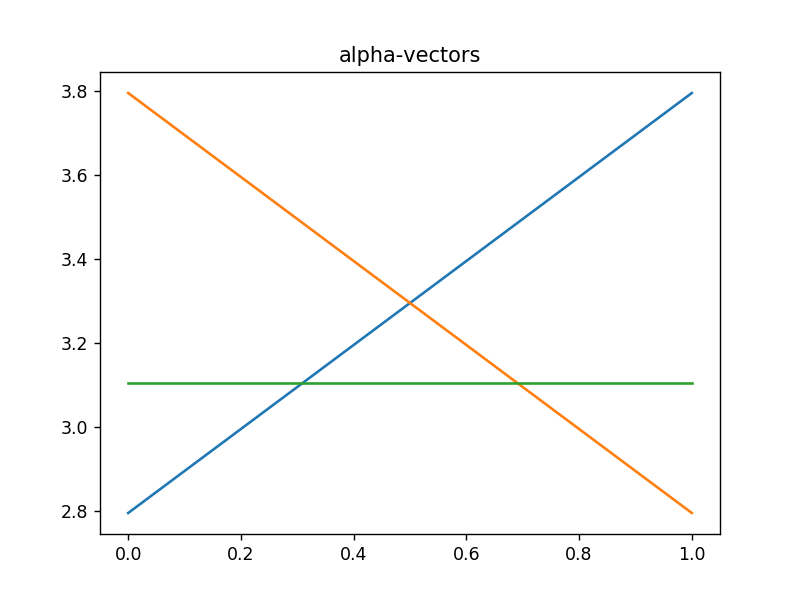

<IPython.core.display.Javascript object>


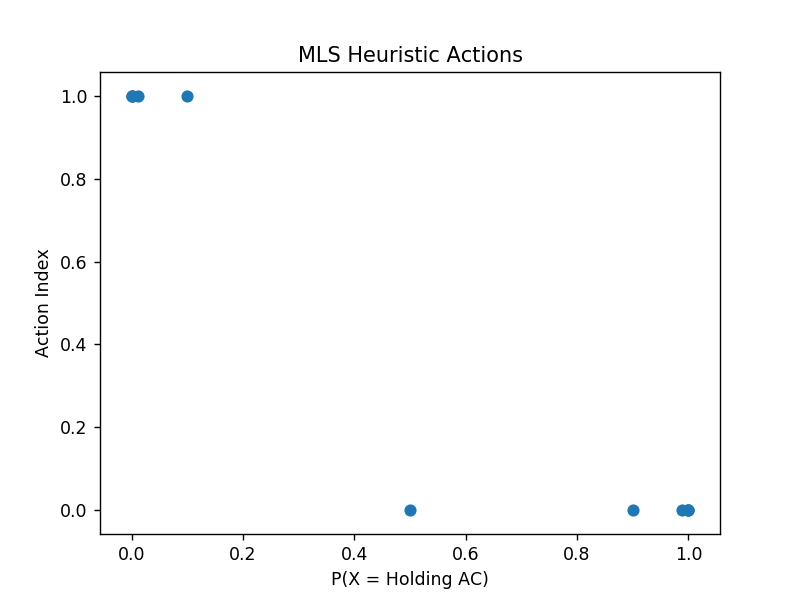

<IPython.core.display.Javascript object>


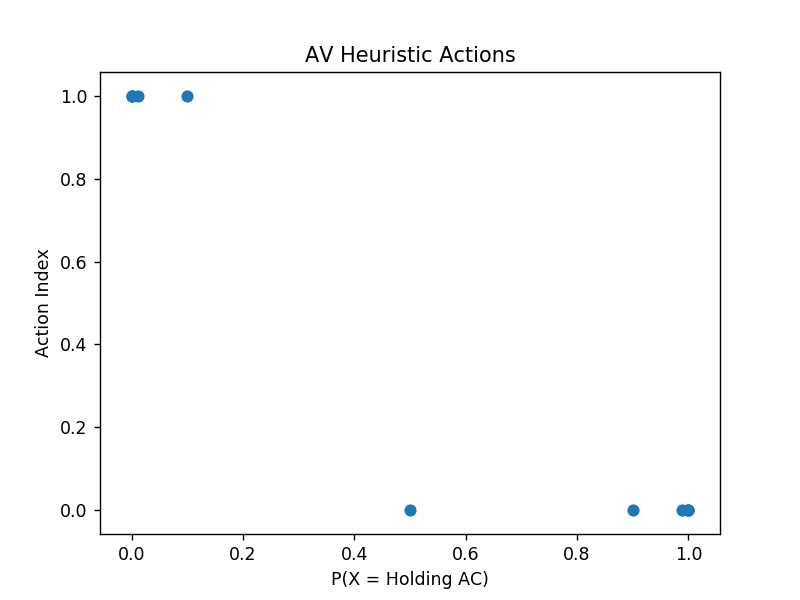

<IPython.core.display.Javascript object>


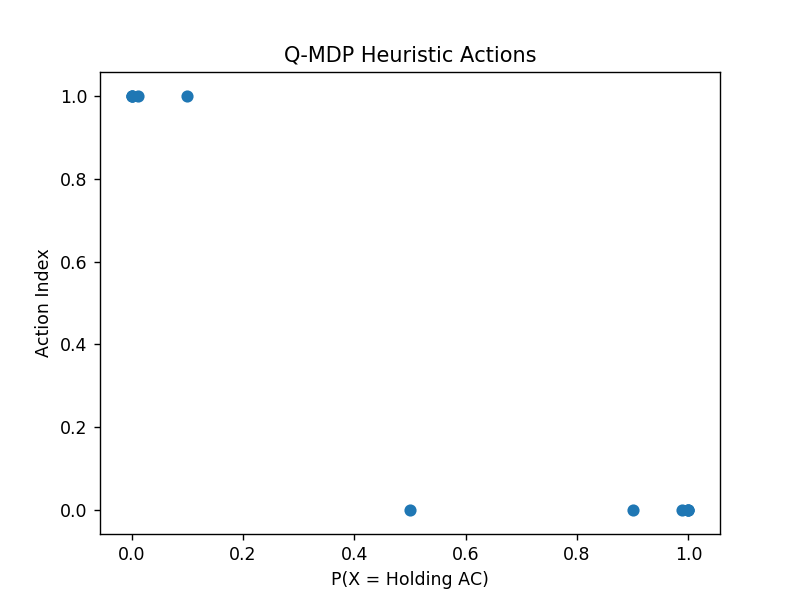

In [9]:
%matplotlib notebook

import matplotlib.pyplot as plt

## Plotting the a-vectors ##
plt.figure(1)
plt.title("alpha-vectors")
plt.plot([2.795, 3.795])
plt.plot([3.795, 2.795])
plt.plot([3.105, 3.105])
plt.show()

## Plotting the actions prescribed the the heuristics ##

## MLS Heuristic ##
plt.figure(2)
plt.title("MLS Heuristic Actions")
plt.xlabel("P(X = Holding AC)")
plt.ylabel("Action Index")
x_mls = []
values_mls = []
for belief in belief_sequence:
    x_mls += [belief[0]] #Probability of Holding AC
    
for action in mls_actions:
    values_mls += [A.index(action)]
    
plt.scatter(x_mls, values_mls)

plt.show()

## AV Heuristic ##
plt.figure(3)
plt.title("AV Heuristic Actions")
plt.xlabel("P(X = Holding AC)")
plt.ylabel("Action Index")
x_av = []
values_av = []
for belief in belief_sequence:
    x_av += [belief[0]] #Probability of Holding AC
    
for action in av_actions:
    values_av += [A.index(action)]
    
plt.scatter(x_av, values_av)
plt.show()

## Q-MDP Heuristic ##
plt.figure(4)
plt.title("Q-MDP Heuristic Actions")
plt.xlabel("P(X = Holding AC)")
plt.ylabel("Action Index")
x_q = []
values_q = []
for belief in belief_sequence:
    x_q += [belief[0]] #Probability of Holding AC
    
for action in q_mdp_actions:
    values_q += [A.index(action)]
    
plt.scatter(x_q, values_q)
plt.show()

#beliefs->que açao tomar
#probabilidade de AC no eixo do x; ação de cada heuristica no y